<a href="https://colab.research.google.com/github/nedokormysh/Stepik_Competitive_DS/blob/week_6/solution_6_4_1_%2B%2B%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Условие

**Задача: Обучи модели для блендинга и стекинга, выбери лучшие**

Датасеты: quickstart_train.csv и quickstart_test.csv.

Регрессионный таргет: столбец target_reg , метрика RMSE.

Для блендинга и стекинга выбрать 3 модели:

Любые 2 бустинга на ваш выбор.
Любую другую модель (не бустинг).
Для стекинга в качестве метамодели желательно взять простой алгоритм (регрессию, KNN и т. п.).

Далее реализуем блендинг и стекинг и делаем финальное предсказание:

* можно выбрать предсказание от блендинга;
* можно от стекинга;
* можно ансамбль блендинга и стекинга;
* можно блендинг блендинга и стекинга с весами 🙈.

**Дополнительные условия:**

Особенно ничем вас не ограничиваем, можно пользоваться всем арсеналом: подбирать гиперпараметры в Optuna, генерить\отбирать признаки и т. п. Но желательно сосредоточиться на освоении блендинга со стекингом и подбором моделей для них.
Сохраняем в submission.csv только колонки car_id и target_reg.
В конце добавляем выводы о проделанных экспериментах, что зашло\не зашло.
Желательно, чтобы на выполнение всего ноутбука уходило не более 30 мин.

**Критерии оценки (максимум 10 баллов за задание):**

*Оформление (3 балла)*

прослеживается логика в последовательности решения задачи; в неочевидных местах добавлены поясняющие комментарии и маркдаун ячейки; ноутбук не перегружен лишней информацией, огромными простынями аутпутов ячеек (настраиваем verbose, скрываем служебную информацию после установки библиотек);
хороший codestyle: код соответствует PEP 8 и DRY, названия переменных и функций понятны либо соответствуют общепринятым нормам (train, test, model, pd, xgb и т. п.);
в конце присутствуют выводы о проделанных экспериментах.

*Решение задачи и выполнение доп. условий (3 балла)*

ноутбук выполняется до конца без ошибок (присутствуют все аутпуты в пдф);
реализованы блендинг со стекингом и выполнены доп. условия;
проведена работа над воспроизводимостью (зафиксированы все random seeds).

*Использование возможностей фреймворка (2 балла)*

корректная подготовка данных для использования в ансамбле;
используется early_stopping, многопоточность (n_threads) и пр.;
правильная подготовка категориальных признаков для каждой модели;
корректное использование пайплайнов и функций sklearn или другой библиотеки.

*Дополнительные баллы (макс. 2 балла)*

* 1 балл, если проводился подбор гиперпараметров;
* 1 балл, если использованы минимум 2 вида графики, и на основе их сделаны какие-либо выводы (не просто график ради красивой картинки, а с пользой для дела);
* 1 балл, если для ансамблей использовались библиотеки, не затронутые или кратко упомянутые в уроках (pystacknet и пр.);
* 1 балл, если использовались ансамблевые методы, не затронутые в уроках (стекинг с фичами, стекинг с весами и пр.).

In [1]:
!pip install catboost -q
!pip install pytorch-tabnet -q
!pip install optuna -q
!pip install gerrychain -q
# !pip install lightgbm -q
# !pip install xgboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 799.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 1.5 MB/s eta 0:00:00


# Загрузка библиотек

In [98]:
from typing import Any
import re

from gerrychain.random import random

import pandas as pd
import numpy as np
import seaborn as sns
import time

import optuna
from optuna.integration import CatBoostPruningCallback, LightGBMPruningCallback, XGBoostPruningCallback
from optuna.integration.pytorch_lightning import PyTorchLightningPruningCallback
# optuna.logging.set_verbosity(optuna.logging.WARNING)

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
import lightgbm as lgb
from lightgbm import LGBMRegressor, early_stopping, Dataset
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, StackingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import NuSVR

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

from torch.utils.data import Dataset, DataLoader
import torch
from torch import nn
import copy

import pickle
import warnings
warnings.simplefilter('ignore')

In [3]:
# фиксируем random state согласно инструкции для optuna
!export PYTHONHASHSEED=0
random.seed(7575)

# Загрузка данных

In [4]:
start = time.time()

In [5]:
PATH_TRAIN = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_train.csv'
PATH_TEST = 'https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/quickstart_test.csv'

## Оптимизируем объём памяти.

In [6]:
def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

def import_data(file: str)-> pd.DataFrame:
    """create a dataframe and optimize its memory usage"""
    df = pd.read_csv(file, parse_dates=True, keep_date_col=True)
    df = reduce_mem_usage(df)
    return df

In [7]:
print('train')
train = import_data(PATH_TRAIN)

print('-' * 80)
print('test')
test = import_data(PATH_TEST)

train
Memory usage of dataframe is 0.30 MB
Memory usage after optimization is: 0.16 MB
Decreased by 47.7%
--------------------------------------------------------------------------------
test
Memory usage of dataframe is 0.23 MB
Memory usage after optimization is: 0.14 MB
Decreased by 40.9%


## Подготовка данных

array([[<Axes: title={'center': 'car_rating'}>,
        <Axes: title={'center': 'year_to_start'}>,
        <Axes: title={'center': 'riders'}>,
        <Axes: title={'center': 'year_to_work'}>,
        <Axes: title={'center': 'target_reg'}>],
       [<Axes: title={'center': 'mean_rating'}>,
        <Axes: title={'center': 'distance_sum'}>,
        <Axes: title={'center': 'rating_min'}>,
        <Axes: title={'center': 'speed_max'}>,
        <Axes: title={'center': 'user_ride_quality_median'}>],
       [<Axes: title={'center': 'deviation_normal_count'}>,
        <Axes: title={'center': 'user_uniq'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

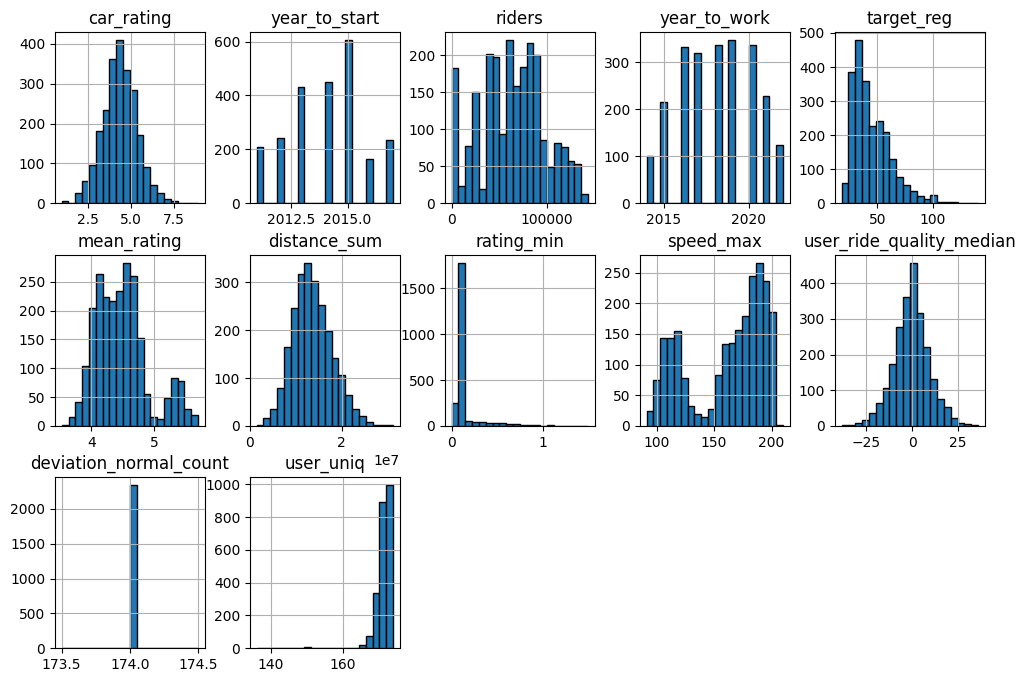

In [8]:
train.hist(figsize=(12,8), layout=(-1,5), bins=20, edgecolor='black')

На гистограммах сразу видно, что признак deviation_normal_count - константный, поэтому не будем его использовать для обучения. Также видно, что числовые признаки придётся стандартизировать для обучения, особенно не бустинговых моделей. Также потребуется стандартизировать и целевую переменную.

In [9]:
# инициализируем листы числовых, категориальных, целевых признаков и признаки, которые не потребуются для анализа.
cat_features = ['model', 'car_type', 'fuel_type']
cat_features_indxs = [0, 1, 2]
targets = [#'target_class',
           'target_reg']
features2drop = ['car_id', 'deviation_normal_count', 'target_class']

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print(f'\033[1mcat_features:\033[0m {cat_features}, \033[1mamount\033[0m = {len(cat_features)}')
print(f'\033[1mnum_features:\033[0m {num_features}, \033[1mamount\033[0m = {len(num_features)}')
print(f'\033[1mtargets:\033[0m {targets}, \033[1mamount\033[0m = {len(targets)}')

cat_features: ['model', 'car_type', 'fuel_type'], amount = 3
num_features: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'user_uniq'], amount = 10
targets: ['target_reg'], amount = 1


In [10]:
# Заменим тип данных object на category в категориальных признаках

for col in cat_features:
    train[col] = train[col].astype("category")

for col in cat_features:
    test[col] = test[col].astype("category")

In [11]:
# инициализируем номер случайного состояния, словарь лучших моделей, словарь для результатов
# датасет для формирования результатов
R_S = 7575
n_est = 400
sampler = optuna.samplers.TPESampler(seed=R_S)

bst_mdls = {}
mean_scores = {}

df_sub = pd.DataFrame(test['car_id'])

In [12]:
# получаем разбиение на фичи и целевую переменную
X = train[filtered_features].drop(targets, axis=1, errors="ignore")
y = train["target_reg"]

# разбиение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=R_S)

# подготовка тестовых данных
X_sub = test[filtered_features].drop(targets, axis=1, errors="ignore")

## Вспомогательные функции и классы

### Класс для нормализации цифровых признаков

Т.к. catboost может работать с категориальными признаками самостоятельно, то будем подавать dataframe в нашу модель. При этом стандартизируем числовые признаки. (пусть для модели catboost, насколько я понимаю, это и не принципиальное действие). Для этого напишем кастомный класс transformer.

In [13]:
class CustomTransformer(TransformerMixin):
    '''
    .. notes::
    Класс трансформации признаков.
    Числовые данные нормализуются или стандартизируются.
    Категориальные признаки не изменяются.
    После трансформаци возвращается датафрейм.
    '''
    def __init__(self,
                 scaler_type: Any=None,
                 cat_feats: list[str]=None,
                 with_mean: bool=True,
                 with_std: bool=True,
                 feature_range: tuple[int, int]=(0, 1)):

        self.scaler_type = scaler_type
        if scaler_type:
            self.scaler = StandardScaler(with_mean=with_mean, with_std=with_std)
        else:
            self.scaler = MinMaxScaler(feature_range=feature_range)

        self.cat_feats = cat_feats

        # print('Init done')
    def fit(self, X: pd.DataFrame, y: pd.Series=None):
        return self

    def transform(self, X: pd.DataFrame, y: pd.Series=None) -> pd.DataFrame:
        X_ = X.copy()
        X_cat = X_[self.cat_feats]
        num_feats = [i for i in X_.columns if i not in self.cat_feats]
        X_num = X_[num_feats]
        X_num = pd.DataFrame(self.scaler.fit_transform(X_num), columns=num_feats)

        res = pd.concat([X_cat.reset_index(), X_num], axis=1)
        return res.set_index('index')

### Класс для нормализации и преобразования для нейронной сети.

Для Tabnet регрессора хотим стандартизировать числовые признаки, при этом категориальные закодировать числами. И на вход tabnet будем подавать массив. Ещё один кастомный класс transformer.

In [14]:
class CustomTransformerNN(TransformerMixin):
    '''
    .. notes::
    Класс трансформации признаков.
    Числовые данные нормализуются или стандартизируются.
    Категориальные признаки кодируютя числами.
    После трансформации получаем.
    '''
    def __init__(self, scaler_type=None, cat_feats=None, with_mean=True, with_std=True, feature_range=(0, 1)):
        self.scaler_type = scaler_type
        if scaler_type:
            self.scaler = StandardScaler(with_mean=with_mean, with_std=with_std,)
        else:
            self.scaler = MinMaxScaler(feature_range=feature_range)

        self.cat_feats = cat_feats

        # print('Init done')
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None) -> np.array:
        X_ = X.copy()
        X_cat = X_[self.cat_feats]
        for col in cat_features:
            X_cat[col] = X_cat[col].replace(np.unique(X_cat[col]), np.arange(X_cat[col].nunique()))
        num_feats = [i for i in X_.columns if i not in self.cat_feats]
        X_num = X_[num_feats]
        X_num = pd.DataFrame(self.scaler.fit_transform(X_num), columns=num_feats)

        res = pd.concat([X_cat.reset_index(), X_num], axis=1)
        return res.set_index('index').values

### Функция для шага обучения

будем использовать scheduler в моделях LGBM и XGB

In [15]:
# функция для шага обучения
def lr_gen_simple(init_lr: float=0.1, epoch: int=400) -> list[float]:
    '''
    :param init_lr: initial number for learning rate
    :type init_lr: float, defaults to 0.1
    :param epoch: amount of epochs
    :type epoch: int, defaults to 400

    :rtype: list[float]

    .. notes:: Функция для формирования листа со значениями шага обучения
    на каждой эпохе.
    -----
    Параметры:
    init_lr - инициализирующий шаг обучения
    epoch - количество эпох

    '''
    decay = init_lr / epoch
    lr_list = [init_lr/(1 + decay * i) for i in range(1, epoch + 1)]

    return lr_list

### Класс для применения моделей.

Соберём класс, в котором будут лежать 2 функции: preparing_features и fit.

preparing_features будет готовить пайплайн для обработки признаков и применения модели. (часть для обработки признаков будет возвраться отдельно). Для catboost и tabnet будем использовать кастомные классы обработки признаков, которые ввели выше. Для остальных моделей: числовые признаки - стандартизируем, категориальные преобразуем при помощи one hot encoding.

fit собственно будет применять нашу модель. Возвращать обученную модель и предсказания.

In [16]:
class FitClass():
    '''
    Класс для применения моделей.
    preparing_features - фунция для создания пайплайнов обработки
    fit - примененение модели
    '''
    @staticmethod
    def preparing_features(name: str, algorithm: Any) -> tuple[Any, Any]:
        '''
        :param name: name of regressor algorithm
        :type name: str
        :param algorithm: class of regressor algorithm
        :type algorithm: Any

        :rtype: tuple[Any, Any]
        :returns: preprocessor pipe for columns and pipe model

        .. notes::
        -----
        Принимает на вход название алгоритма и алгоритм.
        Возвращает цепочку для преобразования фичей,
        цепочку для преобразования фичей и применения модели.
        '''

        if name == 'CatBoostRegressor':
              preprocessor = CustomTransformer(True, cat_feats=cat_features)

              pipe = Pipeline([('feature_preprocessor', preprocessor),
                              ('model', algorithm)])
        elif name == 'TabNetRegressor':
            preprocessor = CustomTransformerNN(True, cat_feats=cat_features)

            pipe = Pipeline([('feature_preprocessor', preprocessor),
                              ('model', algorithm)])
        else:
            numeric_transformer = Pipeline(
                steps=[("imputer", SimpleImputer(strategy="median")),
                      ("scaler", StandardScaler())])
            categorical_transformer = Pipeline(
                steps=[("encoder", OneHotEncoder(handle_unknown="ignore")),
                      #  ("selector", SelectPercentile(chi2, percentile=50)),
                      ])
            preprocessor = ColumnTransformer(
                transformers=[("num", numeric_transformer, num_features),
                              ("cat", categorical_transformer, cat_features)])

            pipe = Pipeline([('feature_preprocessor', preprocessor),
                            ('model', algorithm)])

        return preprocessor, pipe

    @staticmethod
    def fit(name: str,
            pipe: Any,
            preprocessor: Any,
            X_train: pd.DataFrame,
            X_val: pd.DataFrame,
            y_train: pd.Series,
            y_val: pd.Series,
            fit_params: dict,
            callbacks=[]):
        '''
        :param name: name of regressor algorithm
        :type name: str
        :param pipe: pipe of preprocessor for features and model
        :type pipe: Any
        :param preprocessor: pipe of preprocessor for features
        :type preprocessor: Any
        :param X_train: train features
        :type X_train: pandas.DataFrame
        :param X_val: validation features
        :type X_val: pandas.DataFrame
        :param y_train: train targer
        :type y_train: pandas.Series
        :param y_val: validation target
        :type y_val: pandas.Series

        :rtype: tuple[np.array, Any]
        :returns: array of predictions, model
        .. notes::
        -----
        Принимает название алгоритма. Применяет алгоритм с заданными параметрами
        к данным.
        Возвращает предсказание. И обученную модель.
        '''
        if name == 'TabNetRegressor':
            target_sc = StandardScaler()
            y_train = target_sc.fit_transform(y_train.values.reshape(-1, 1))
            X_val_eval_NN = X_val.copy()
            eval_set_pipe = Pipeline(steps = [('feature_preprocessor', preprocessor)])
            X_val_eval_NN = eval_set_pipe.fit(X_train).transform(X_val_eval_NN)
            y_val_eval_NN = target_sc.transform(y_val.values.reshape(-1, 1))
        else:
            X_val_eval = X_val.copy()
            eval_set_pipe = Pipeline(steps = [('feature_preprocessor', preprocessor)])
            X_val_eval = eval_set_pipe.fit(X_train).transform(X_val_eval)

        wrapped_model = TransformedTargetRegressor(regressor=pipe, transformer=StandardScaler())

        if name in ['KNeighborsRegressor', 'ElasticNet', 'RandomForestRegressor', 'GaussianProcessRegressor', 'NuSVR', 'MLPRegressor', 'GradientBoostingRegressor']:
            wrapped_model.fit(X_train,
                              y_train,
                              **fit_params)
            y_pred = wrapped_model.predict(X_val)
        elif name == 'TabNetRegressor':
            pipe.fit(X_train, y_train,
                    model__eval_set=[(X_val_eval_NN, y_val_eval_NN)],
                    **fit_params)
            y_pred = pipe.predict(X_val)
            y_pred = target_sc.inverse_transform(np.array(y_pred).reshape(-1, 1))
            wrapped_model = pipe

        else:
            if callbacks:
                wrapped_model.fit(X_train,
                                  y_train,
                                  **fit_params,
                                  model__callbacks=callbacks,
                                  model__eval_set=[(X_val_eval, y_val)])
                # запускаем процесс прунинга для catboost
                if name == 'CatBoostRegressor':
                    callbacks[-1].check_pruned()
            else:
                wrapped_model.fit(X_train,
                                  y_train,
                                  model__eval_set=[(X_val_eval, y_val)],
                                  **fit_params)

            y_pred = wrapped_model.predict(X_val)

        if name == 'TabNetRegressor':
            return y_pred, wrapped_model, target_sc

        return y_pred, wrapped_model

### Fit algorithm optuna

Объявим функцию обучения для всех моделей. Будем использовать механизм подбора гиперпараметров optuna.

In [17]:
# функция применения алгоритма, когда применяем optuna
def fit_algorithm_optuna(trial: optuna.trial,
                         train: pd.DataFrame,
                         val: pd.DataFrame,
                         algorithm: Any,
                         init_params: dict,
                         grid: dict,
                         fit_params: dict,
                         r_s=R_S,
                         callbacks = []):
    '''
    :param trial: standart optuna parameter
    :type trial: optuna.trial
    :param train: train dataframe
    :type train: pandas.DataFrame
    :param val: validation dataframe
    :type val: pd.DataFrame
    :param algorithm: class of regressor algorithm
    :type algorithm: Any
    :param init_params: initial parameters
    :type init_params: dict
    :param grid: grid of parameters
    :type grid: dict
    :param fit_params: parameters to fit
    :type fit_params: dict
    :param r_s: random state
    :type r_s: int, defaults to 7575
    :param callbacks: callbacks
    :type callbacks: list, defaults to []

    :rtype: tuple[Any, np.array]
    :returns: model, array of predictions
    .. notes::
    -----
    Принимает объект trial из optuna, данные для обучения и валидации, алгоритм, параметры.
    Алгоритм обучается и применяется.
    Возвращает обученную модель и предсказанное значение для валидационной выборки.
    '''

    X_train, y_train = train
    X_val, y_val = val

    # получаем на вход сетку с параметрами для перебора. для пары алгоритмов будем
    # добавлять параметры в сетку, в зависимости от некоторых условий.
    if algorithm.__name__ == 'CatBoostRegressor':
        if grid["bootstrap_type"] == "Bayesian":
            grid["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 20)

        elif grid["bootstrap_type"] == "Bernoulli":
            grid["subsample"] = trial.suggest_float("subsample", 0.1, 1)
    elif algorithm.__name__ == 'XGBRegressor':
        if grid["booster"] == "gbtree" or grid["booster"] == "dart":
            grid["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            grid["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            grid["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            grid["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
            grid["tree_method"]: trial.suggest_categorical("tree_method", ['hist', 'approx'],)
        if grid["booster"] == "dart":
            grid["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
            grid["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
            grid["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
            grid["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
    rgr = algorithm(**init_params, **grid)

    # применяем метод preparing_features - он на вернёт способ обработки данных и общий пайплайн модели
    preprocessor, pipe = FitClass.preparing_features(algorithm.__name__, rgr)
    # для алгоритма TabNet будем возвращать ещё и обученный объект scaler для целевой переменной
    if algorithm.__name__ == 'TabNetRegressor':
        y_pred, wrapped_model, target_sc = FitClass.fit(algorithm.__name__, pipe, preprocessor, X_train, X_val, y_train, y_val, fit_params, callbacks)
        return wrapped_model, y_pred, target_sc

    y_pred, wrapped_model = FitClass.fit(algorithm.__name__, pipe, preprocessor, X_train, X_val, y_train, y_val, fit_params, callbacks)
    # возвращаем модель и прогноз
    return wrapped_model, y_pred

# Модели

## Catboost

In [18]:
# функция для рассчёта метрики в механизме перебора optuna
def objective_catboost(trial: optuna.trial, return_models:bool=False):

    '''
    :param trial: standart optuna parameter
    :type trial: optuna.trial
    :param return_models: parameter to return fitted model or not
    :type return_models: bool, defaults to False

    :rtype: float | tuple[float, Any]
    :returns: mean value of RMSE on folds, model
    .. notes::
    -----
    Принимает объект trial из optuna и булево значение для возможности возврата модели.

    Разбиваем данные на фолды, и подаём в функцию fit algorithm_optuna на каждом разбиении.

    '''
    # будем использовать pruning
    pruning_callback = CatBoostPruningCallback(trial, "RMSE")
    callbacks = [pruning_callback]

    # параметры, которые не будем перебирать
    init_params = {'loss_function': 'RMSE',
                   'random_seed': R_S,
                   'thread_count': -1,
                   'verbose': 0,
                   'task_type': "CPU",
                   'iterations' : n_est, # Можно не перебирать, есть Early-Stopping,
                   'cat_features': cat_features}
    # сетка с параметрами для перебора
    grid = {'learning_rate': trial.suggest_float("learning_rate", 0.019, 0.026),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 300, 400),
            'l2_leaf_reg': trial.suggest_int("l2_leaf_reg", 2, 10),
            'max_bin': trial.suggest_int('max_bin', 200, 300),
            'boosting_type': trial.suggest_categorical("boosting_type", ["Ordered",
                                                                        #  "Plain"
                                                                         ]),
            'bootstrap_type': trial.suggest_categorical("bootstrap_type", [#"Bayesian",
                                                                           #"Bernoulli",
                                                                           "MVS"]),
            'depth': trial.suggest_int("depth", 8, 11),
            'colsample_bylevel': trial.suggest_float("colsample_bylevel", 0.61, 0.64),
            # 'subsample': trial.suggest_float("colsample_bylevel", 0.01, 0.95),
            'used_ram_limit': "14gb"}

    # параметры для применения модели. используем early stopping
    fit_params = {'model__cat_features': cat_features,
                  'model__verbose': 0,
                  'model__early_stopping_rounds': 200,
                  'model__plot': False}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)
    # разбиваем на фолды
    scores, models = [], []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Разбиваем на обучающую и валидационную выборки. Подаём данные, параметры и тип алгоритма функцию
        # fit_algorithm_optuna, которая вернёт нам модель и прогноз для валидационных данных

        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             CatBoostRegressor,
                                             init_params,
                                             grid,
                                             fit_params,
                                             callbacks=callbacks)
        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        break
    # записываем лучшие модели и результат по фолдам
    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [19]:
%%time
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            #  pruner=optuna.pruners.HyperbandPruner(),
                            direction="minimize", study_name="Catboost_Regressor", sampler=sampler)
study.optimize(objective_catboost,
               n_trials=50,
               n_jobs=-1,
               show_progress_bar=True)

[I 2023-08-27 13:30:36,172] A new study created in memory with name: Catboost_Regressor


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-08-27 13:30:55,292] Trial 0 finished with value: 11.753035359558847 and parameters: {'learning_rate': 0.021569841601802413, 'min_data_in_leaf': 389, 'l2_leaf_reg': 9, 'max_bin': 259, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'depth': 8, 'colsample_bylevel': 0.6140879548468382}. Best is trial 0 with value: 11.753035359558847.
[I 2023-08-27 13:31:33,903] Trial 1 finished with value: 11.659689681204295 and parameters: {'learning_rate': 0.02564436046004559, 'min_data_in_leaf': 361, 'l2_leaf_reg': 5, 'max_bin': 249, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'depth': 11, 'colsample_bylevel': 0.6285545111754242}. Best is trial 1 with value: 11.659689681204295.
[I 2023-08-27 13:31:52,903] Trial 2 finished with value: 11.704167399085346 and parameters: {'learning_rate': 0.02444426244727006, 'min_data_in_leaf': 398, 'l2_leaf_reg': 6, 'max_bin': 225, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS', 'depth': 11, 'colsample_bylevel': 0.620334457550273}. Best is tri

In [20]:
# optuna.visualization.plot_optimization_history(study)

In [21]:
# params = ['learning_rate',
#           'min_data_in_leaf',
#           'l2_leaf_reg',
#           'max_bin',
#           'boosting_type',
#           'bootstrap_type',
#           'depth',
#           'colsample_bylevel']

# optuna.visualization.plot_slice(study, params=params, target_name='rmse')

In [22]:
# optuna.visualization.plot_param_importances(study)

Для уменьшения времени работы всего ноутбука все параметры были несколько раз подобраны с помощью optuna и изменены диапазоны параметров, а также выброшены какие-то параметры.

In [23]:
mean_scores['Catboost_score'], bst_mdls['Catboost_model'] = objective_catboost(optuna.trial.FixedTrial(study.best_params), return_models=True)

In [24]:
# Сделаем прогноз для тестовых данных
preds = bst_mdls['Catboost_model'].predict(X_sub)
# Добавляем наши предсказания для тестовой выборки в таблицу результатов
df_sub['Catboost_target'] = preds
df_sub.head()

,car_id,Catboost_target
0,P17494612l,44.369841
1,N-1530212S,32.047822
2,B-1154399t,32.821089
3,F12725233R,33.103890
4,l-1139189J,32.065330


## LGBM

In [25]:
def objective_lgbm(trial, return_models=False):

    pruning_callback = LightGBMPruningCallback(trial, "rmse")

    callbacks = [
                 lgb.early_stopping(stopping_rounds=50, verbose=0),
                 lgb.reset_parameter(learning_rate=lr_gen_simple(trial.suggest_float("lr_init", 0.0001, 0.5), n_est)),
                #  pruning_callback
                ]

    init_params = {'metric': "RMSE",
                   'objective': 'regression',
                   'boosting_type': trial.suggest_categorical("boosting_type",
                                                              [ "gbdt",
                                                                "dart"
                                                                ]),
                   'random_seed': R_S,
                   'n_jobs': -1,
                   'verbose': -1,
                   'force_row_wise': True,
                   'num_iterations' : n_est, # Можно не перебирать, есть Early-Stopping
                  #  'cat_features': cat_features
                   }

    grid = {
            #  'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.01),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
            'reg_alpha': trial.suggest_int("reg_alpha", 1e-3, 1),
            'reg_lambda': trial.suggest_int("reg_lambda", 1e-3, 1),
            # 'max_bin': trial.suggest_int('max_bin', 100, 300),
            'num_leaves': trial.suggest_int('num_leaves', 4, 7),
            'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 0.95),
            'subsample': trial.suggest_float("subsample", 0.5, 1),
        }

    fit_params = { }

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []


    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                      train_data,
                                      valid_data,
                                      LGBMRegressor,
                                      init_params,
                                      grid,
                                      fit_params,
                                      callbacks=callbacks)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    # print('scores', scores)
    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [26]:
%%time
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            direction="minimize", study_name="LGBM_Regressor", sampler=sampler)
study.optimize(objective_lgbm,
               n_trials=100,
               n_jobs=-1,
               show_progress_bar=True,)

[I 2023-08-27 13:34:06,418] A new study created in memory with name: LGBM_Regressor


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-08-27 13:34:07,525] Trial 0 finished with value: 12.118260797614534 and parameters: {'lr_init': 0.2589071326019654, 'boosting_type': 'gbdt', 'min_child_samples': 34, 'reg_alpha': 1, 'reg_lambda': 1, 'num_leaves': 4, 'colsample_bytree': 0.5001737874639297, 'subsample': 0.5653539775803114}. Best is trial 0 with value: 12.118260797614534.
[I 2023-08-27 13:34:08,336] Trial 1 finished with value: 13.19097671339789 and parameters: {'lr_init': 0.4381372034874387, 'boosting_type': 'dart', 'min_child_samples': 39, 'reg_alpha': 0, 'reg_lambda': 0, 'num_leaves': 5, 'colsample_bytree': 0.523504006279823, 'subsample': 0.9592929416708649}. Best is trial 0 with value: 12.118260797614534.
[I 2023-08-27 13:34:08,755] Trial 2 finished with value: 12.301748091030488 and parameters: {'lr_init': 0.2682700608007345, 'boosting_type': 'gbdt', 'min_child_samples': 36, 'reg_alpha': 0, 'reg_lambda': 1, 'num_leaves': 6, 'colsample_bytree': 0.6163033512537301, 'subsample': 0.6868883572057949}. Best is tria

In [27]:
# params = ['min_child_samples',
#           'reg_alpha',
#           'reg_lambda',
#           'num_leaves',
#           'colsample_bytree',
#           'subsample',]

# optuna.visualization.plot_slice(study, params=params, target_name='rmse')

In [28]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['LGBM_score'], bst_mdls['LGBM_model'] = objective_lgbm(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 11.558336426974305, params {'lr_init': 0.022786633562687692, 'boosting_type': 'gbdt', 'min_child_samples': 13, 'reg_alpha': 1, 'reg_lambda': 1, 'num_leaves': 7, 'colsample_bytree': 0.6204542388044181, 'subsample': 0.644766582412028}
[LightGBM] [Info] Start training from score -0.000030
[LightGBM] [Info] Start training from score -0.000002
[LightGBM] [Info] Start training from score -0.000034


In [29]:
preds = bst_mdls['LGBM_model'].predict(X_sub)

df_sub['LGBM_target'] = preds
# df_sub.head()

## TabNet

In [34]:
def objective_tabnet(trial, return_models=False):

    init_params = {'device_name':'cpu',
                   'cat_idxs': cat_features_indxs,
                   'cat_dims': [26, 4, 2],
                   'verbose': 0,
                  #  'verbose_eval': 0,
                   'seed': R_S,
                   'optimizer_fn': torch.optim.Adam,
                   'optimizer_params': dict(lr=2e-2, weight_decay=1e-5),
                   'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau}

    grid = {'mask_type': trial.suggest_categorical("mask_type", [# "sparsemax",
                                                                  "entmax"]),
             'n_d': 12,
             'n_a': 10,
             'n_steps': trial.suggest_int("n_steps", 2, 3),
             'gamma': trial.suggest_float("gamma", 1.35, 1.4),
             'cat_emb_dim': trial.suggest_int("cat_emb_dim", 6, 8),
             'n_independent': trial.suggest_int("n_independent", 4, 5),
             'n_shared': trial.suggest_int("n_shared", 3, 4),
             'momentum': trial.suggest_float("momentum", .06, .1),
             'lambda_sparse': trial.suggest_float("lambda_sparse", 1e-6, 1e-4, log=True),
             'scheduler_params': dict(mode="min",
                                      min_lr=1e-5,
                                      factor=0.5,
                                      # verbose=-1
                                      )
    }

    fit_params = {'model__eval_metric':['rmse'],
                  'model__patience': 24,
                  'model__max_epochs': 170}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models ,scs = [], [], []


    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred, target_sc = fit_algorithm_optuna(trial,
                                                        train_data,
                                                        valid_data,
                                                        TabNetRegressor,
                                                        init_params,
                                                        grid,
                                                        fit_params,
                                                        # callbacks=callbacks
                                                        )

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        scs.append(target_sc)
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    bst_ts = scs[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl, bst_ts
    else:
        return result

In [35]:
%%time
study = optuna.create_study(direction="minimize", study_name="TabNet_Regressor", sampler=sampler)
study.optimize(objective_tabnet,
               n_trials=20,
               n_jobs=-1,
               show_progress_bar=True)

[I 2023-08-27 13:42:41,745] A new study created in memory with name: TabNet_Regressor


  0%|          | 0/20 [00:00<?, ?it/s]


Early stopping occurred at epoch 91 with best_epoch = 67 and best_val_0_rmse = 0.7208799719810486

Early stopping occurred at epoch 72 with best_epoch = 48 and best_val_0_rmse = 0.8076599836349487

Early stopping occurred at epoch 69 with best_epoch = 45 and best_val_0_rmse = 0.746150016784668

Early stopping occurred at epoch 74 with best_epoch = 50 and best_val_0_rmse = 0.7273200154304504
[I 2023-08-27 13:44:08,450] Trial 0 finished with value: 12.90066909790039 and parameters: {'mask_type': 'entmax', 'n_steps': 2, 'gamma': 1.399195109337392, 'cat_emb_dim': 8, 'n_independent': 5, 'n_shared': 4, 'momentum': 0.06545092685475892, 'lambda_sparse': 1.1899403222662296e-06}. Best is trial 0 with value: 12.90066909790039.

Early stopping occurred at epoch 122 with best_epoch = 98 and best_val_0_rmse = 0.7101600170135498

Early stopping occurred at epoch 95 with best_epoch = 71 and best_val_0_rmse = 0.7357000112533569

Early stopping occurred at epoch 59 with best_epoch = 35 and best_val_0_r

In [36]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['TabNet_score'], bst_mdls['TabNet_model'], target_sc = objective_tabnet(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 12.221219062805176, params {'mask_type': 'entmax', 'n_steps': 3, 'gamma': 1.3696107393372625, 'cat_emb_dim': 7, 'n_independent': 5, 'n_shared': 3, 'momentum': 0.07271309229496836, 'lambda_sparse': 3.9817431984061385e-05}

Early stopping occurred at epoch 146 with best_epoch = 122 and best_val_0_rmse = 0.7325500249862671

Early stopping occurred at epoch 81 with best_epoch = 57 and best_val_0_rmse = 0.7117900252342224

Early stopping occurred at epoch 87 with best_epoch = 63 and best_val_0_rmse = 0.6852099895477295


In [38]:
# params = ["mask_type",
#           'n_d',
#           'n_a',
#           'n_steps',
#           'gamma',
#           'cat_emb_dim',
#           'n_independent',
#           'n_shared',
#           'momentum',
#           'lambda_sparse',]

# optuna.visualization.plot_slice(study, params=params, target_name='rmse')

In [37]:
preds = bst_mdls['TabNet_model'].predict(X_sub)
preds = target_sc.inverse_transform(np.array(preds).reshape(-1, 1))

df_sub['TabNet_target'] = preds
# df_sub.head()

## KNN regressor

In [63]:
def objective_knn(trial, return_models=False):
    init_params = { 'n_jobs': -1 }

    grid = {
             'weights': trial.suggest_categorical("weights", ['distance',
                                                              # 'uniform'
                                                              ],),
             'n_neighbors': trial.suggest_int("n_neighbors", 100, 200, step=4),
             'leaf_size': trial.suggest_int("leaf_size", 200, 300, step=4),
             'p':  trial.suggest_int("p", 1, 2)
             }

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             KNeighborsRegressor,
                                             init_params,
                                             grid,
                                             fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [64]:
%%time
study = optuna.create_study(direction="minimize", study_name="KNN_Regressor", sampler=sampler)
study.optimize(objective_knn,
               n_trials=80,
               n_jobs=-1,
               show_progress_bar=True,)

[I 2023-08-27 14:15:46,710] A new study created in memory with name: KNN_Regressor


  0%|          | 0/80 [00:00<?, ?it/s]

[I 2023-08-27 14:15:47,366] Trial 0 finished with value: 15.213869228032072 and parameters: {'weights': 'distance', 'n_neighbors': 164, 'leaf_size': 248, 'p': 2}. Best is trial 0 with value: 15.213869228032072.
[I 2023-08-27 14:15:47,448] Trial 1 finished with value: 15.38422467333496 and parameters: {'weights': 'distance', 'n_neighbors': 200, 'leaf_size': 264, 'p': 2}. Best is trial 0 with value: 15.213869228032072.
[I 2023-08-27 14:15:48,117] Trial 3 finished with value: 15.131135065051767 and parameters: {'weights': 'distance', 'n_neighbors': 148, 'leaf_size': 268, 'p': 2}. Best is trial 3 with value: 15.131135065051767.
[I 2023-08-27 14:15:48,149] Trial 2 finished with value: 15.044802386119835 and parameters: {'weights': 'distance', 'n_neighbors': 120, 'leaf_size': 280, 'p': 1}. Best is trial 2 with value: 15.044802386119835.
[I 2023-08-27 14:15:48,947] Trial 4 finished with value: 14.92551175232616 and parameters: {'weights': 'distance', 'n_neighbors': 116, 'leaf_size': 276, 'p':

In [65]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['KNN_score'], bst_mdls['KNN_model'] = objective_knn(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 14.80338878265787, params {'weights': 'distance', 'n_neighbors': 100, 'leaf_size': 204, 'p': 2}


In [60]:
# params = ['weights',
#           'n_neighbors',
#           'leaf_size',
#           'p']

# optuna.visualization.plot_slice(study, params=params, target_name='rmse')

In [66]:
preds = bst_mdls['KNN_model'].predict(X_sub)

df_sub['KNN_target'] = preds
# df_sub.head()

## Elastic net regressor

In [73]:
def objective_elastik(trial, return_models=False):
    init_params = {'random_state': R_S,}

    grid = {'max_iter': trial.suggest_int("max_iter", 600, 800, step=4),
            'l1_ratio': trial.suggest_float("l1_ratio", 0.001, .3),
            'alpha':  trial.suggest_float("alpha", 0.001, .3)}

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]


        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                             train_data,
                                             valid_data,
                                             ElasticNet,
                                             init_params,
                                             grid,
                                             fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [74]:
%%time
study = optuna.create_study(direction="minimize", study_name="Elastik_Regressor", sampler=sampler)
study.optimize(objective_elastik,
               n_trials=100,
               n_jobs=-1,
               show_progress_bar=True,)

[I 2023-08-27 14:19:35,448] A new study created in memory with name: Elastik_Regressor


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-08-27 14:19:35,933] Trial 1 finished with value: 14.744465022345798 and parameters: {'max_iter': 768, 'l1_ratio': 0.2629582060055575, 'alpha': 0.08168134261581218}. Best is trial 1 with value: 14.744465022345798.
[I 2023-08-27 14:19:35,975] Trial 0 finished with value: 14.860736162169 and parameters: {'max_iter': 616, 'l1_ratio': 0.0064830217210381956, 'alpha': 0.23329385057542115}. Best is trial 1 with value: 14.744465022345798.
[I 2023-08-27 14:19:36,379] Trial 3 finished with value: 14.578102678993625 and parameters: {'max_iter': 788, 'l1_ratio': 0.04146482412792475, 'alpha': 0.04841780331380352}. Best is trial 3 with value: 14.578102678993625.
[I 2023-08-27 14:19:36,384] Trial 2 finished with value: 14.55998379735505 and parameters: {'max_iter': 668, 'l1_ratio': 0.004195202181593256, 'alpha': 0.039302145610191595}. Best is trial 2 with value: 14.55998379735505.
[I 2023-08-27 14:19:36,761] Trial 4 finished with value: 14.758954917235274 and parameters: {'max_iter': 640, 'l1_

In [76]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['Elastic_score'], bst_mdls['Elastic_model'] = objective_elastik(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 14.54853940911663, params {'max_iter': 760, 'l1_ratio': 0.022093296527625032, 'alpha': 0.012667233071030409}


In [75]:
# params = ['max_iter',
#           'l1_ratio',
#           'alpha']

# optuna.visualization.plot_slice(study, params=params, target_name='rmse')

In [78]:
preds = bst_mdls['Elastic_model'].predict(X_sub)
df_sub['Elastic_target'] = preds
# df_sub.head()

## GradientBoosting regressor

In [93]:
def objective_gradient_boosting(trial, return_models=False):
    init_params = {'random_state': R_S,
                  #  'n_jobs': -1,
                   }

    grid = { #'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.01),
             'n_estimators': trial.suggest_int("n_estimators", 300, 500, step=4),
             'subsample': trial.suggest_float("subsample", 0.6, 0.95),
             'criterion': trial.suggest_categorical("criterion", ["friedman_mse",
                                                                  # "squared_error"
                                                                  ]),
             'min_samples_split': trial.suggest_int("min_samples_split", 2, 200),
             'min_samples_leaf': trial.suggest_int("min_samples_leaf", 2, 200),
             'max_depth': trial.suggest_int("max_depth", 4, 8),
             'n_iter_no_change': trial.suggest_int("n_iter_no_change", 2, 100),
             }

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []


    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]


        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                      train_data,
                                      valid_data,
                                      GradientBoostingRegressor,
                                      init_params,
                                      grid,
                                      fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [94]:
%%time
study = optuna.create_study(direction="minimize", study_name="GB_Regressor", sampler=sampler)
study.optimize(objective_gradient_boosting,
               n_trials=100,
               n_jobs=-1,
               show_progress_bar=True,)

[I 2023-08-27 15:06:38,528] A new study created in memory with name: GB_Regressor


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-08-27 15:06:40,650] Trial 1 finished with value: 13.364687566066012 and parameters: {'n_estimators': 432, 'subsample': 0.8039008744659539, 'criterion': 'friedman_mse', 'min_samples_split': 134, 'min_samples_leaf': 169, 'max_depth': 6, 'n_iter_no_change': 91}. Best is trial 1 with value: 13.364687566066012.
[I 2023-08-27 15:06:41,666] Trial 0 finished with value: 13.22416446778934 and parameters: {'n_estimators': 400, 'subsample': 0.8944516130032062, 'criterion': 'friedman_mse', 'min_samples_split': 77, 'min_samples_leaf': 147, 'max_depth': 6, 'n_iter_no_change': 91}. Best is trial 0 with value: 13.22416446778934.
[I 2023-08-27 15:06:43,033] Trial 2 finished with value: 13.442924446381355 and parameters: {'n_estimators': 380, 'subsample': 0.7709128051400829, 'criterion': 'friedman_mse', 'min_samples_split': 27, 'min_samples_leaf': 200, 'max_depth': 8, 'n_iter_no_change': 65}. Best is trial 0 with value: 13.22416446778934.
[I 2023-08-27 15:06:43,687] Trial 4 finished with value: 

In [89]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['GB_score'], bst_mdls['GB_model'] = objective_gradient_boosting(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 11.558674516567573, params {'n_estimators': 388, 'subsample': 0.8718830109262391, 'criterion': 'friedman_mse', 'min_samples_split': 97, 'min_samples_leaf': 7, 'max_depth': 5, 'n_iter_no_change': 14}


In [91]:
# params = ['n_estimators',
#           'subsample',
#           'criterion',
#           'min_samples_split',
#           'min_samples_leaf',
#           'max_depth',
#           'n_iter_no_change']

# optuna.visualization.plot_slice(study, params=params, target_name='rmse')

In [92]:
preds = bst_mdls['GB_model'].predict(X_sub)
df_sub['GB_target'] = preds

## Random Forest regressor

In [103]:
def objective_random_forest(trial, return_models=False):
    init_params = {'random_state': R_S,
                   'n_jobs': -1}

    grid = { 'n_estimators': trial.suggest_int("n_estimators", 200, 350, step=4),
             'max_depth': trial.suggest_int("max_depth", 8, 11),
             'max_samples': trial.suggest_int("max_samples", 200, 350),
            #  'min_samples_leaf': trial.suggest_int("min_samples_leaf", 50, 150),
             }

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []

    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]

        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                      train_data,
                                      valid_data,
                                      RandomForestRegressor,
                                      init_params,
                                      grid,
                                      fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [104]:
%%time
study = optuna.create_study(direction="minimize", study_name="Random_Forest_Regressor", sampler=sampler)
study.optimize(objective_random_forest,
               n_trials=100,
               n_jobs=-1,
               show_progress_bar=True,)

[I 2023-08-27 15:30:07,510] A new study created in memory with name: Random_Forest_Regressor


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-08-27 15:30:12,524] Trial 0 finished with value: 11.904740577478785 and parameters: {'n_estimators': 204, 'max_depth': 8, 'max_samples': 215}. Best is trial 0 with value: 11.904740577478785.
[I 2023-08-27 15:30:17,152] Trial 1 finished with value: 11.784961401018373 and parameters: {'n_estimators': 344, 'max_depth': 8, 'max_samples': 300}. Best is trial 1 with value: 11.784961401018373.
[I 2023-08-27 15:30:19,060] Trial 2 finished with value: 11.764521739039031 and parameters: {'n_estimators': 220, 'max_depth': 9, 'max_samples': 324}. Best is trial 2 with value: 11.764521739039031.
[I 2023-08-27 15:30:22,675] Trial 3 finished with value: 11.778849639162367 and parameters: {'n_estimators': 232, 'max_depth': 9, 'max_samples': 291}. Best is trial 2 with value: 11.764521739039031.
[I 2023-08-27 15:30:28,784] Trial 4 finished with value: 11.747452400546877 and parameters: {'n_estimators': 312, 'max_depth': 11, 'max_samples': 326}. Best is trial 4 with value: 11.747452400546877.
[I 2

In [105]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['RF_score'], bst_mdls['RF_model'] = objective_random_forest(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 11.722055643624628, params {'n_estimators': 324, 'max_depth': 11, 'max_samples': 345}


In [106]:
# params = ['n_estimators',
#           'max_depth',
#           'max_samples']

# optuna.visualization.plot_slice(study, params=params, target_name='rmse')

In [107]:
preds = bst_mdls['RF_model'].predict(X_sub)
df_sub['RF_target'] = preds

## Gaussian Process regressor

In [112]:
def objective_gaussian(trial, return_models=False):
    init_params = {'random_state': R_S,}

    grid = {'alpha': trial.suggest_float("alpha", 0.001, .4)}

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []


    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]


        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                      train_data,
                                      valid_data,
                                      GaussianProcessRegressor,
                                      init_params,
                                      grid,
                                      fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_pred, y_true, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [113]:
%%time
# optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize", study_name="Gaussian_Regressor")
study.optimize(objective_gaussian,
               n_trials=100,
               n_jobs=-1,
               show_progress_bar=True,)

[I 2023-08-27 15:41:21,011] A new study created in memory with name: Gaussian_Regressor


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2023-08-27 15:41:25,063] Trial 1 finished with value: 14.890615601819647 and parameters: {'alpha': 0.09757601407698752}. Best is trial 1 with value: 14.890615601819647.
[I 2023-08-27 15:41:25,177] Trial 0 finished with value: 14.907810981773608 and parameters: {'alpha': 0.18762188665157015}. Best is trial 1 with value: 14.890615601819647.
[I 2023-08-27 15:41:27,824] Trial 2 finished with value: 14.9468333027905 and parameters: {'alpha': 0.2992755472536264}. Best is trial 1 with value: 14.890615601819647.
[I 2023-08-27 15:41:28,042] Trial 3 finished with value: 14.933690079132937 and parameters: {'alpha': 0.2655006835297705}. Best is trial 1 with value: 14.890615601819647.
[I 2023-08-27 15:41:30,455] Trial 4 finished with value: 14.961391399633866 and parameters: {'alpha': 0.334450132623433}. Best is trial 1 with value: 14.890615601819647.
[I 2023-08-27 15:41:30,801] Trial 5 finished with value: 14.93295175986983 and parameters: {'alpha': 0.26352694537460225}. Best is trial 1 with va

In [114]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['Gauss_score'], bst_mdls['Gauss_model'] = objective_gaussian(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 14.889754981448975, params {'alpha': 0.07617664971938543}


In [115]:
params = ['alpha']

optuna.visualization.plot_slice(study, params=params, target_name='rmse')

In [ ]:
preds = bst_mdls['Gauss_model'].predict(X_sub)

df_sub['Gauss_target'] = preds
df_sub.head()

,car_id,Catboost_target,LGBM_target,TabNet_target,KNN_target,Elastic_target,GB_target,RF_target,Gauss_target
0,P17494612l,46.734139,51.624701,40.758076,42.158554,48.761550,51.224259,42.800623,41.884547
1,N-1530212S,35.766222,34.382361,36.561729,43.264945,46.828036,33.589097,33.414859,43.470195
2,B-1154399t,34.374031,30.583014,33.217117,37.782325,39.100575,29.475658,31.994664,37.710450
3,F12725233R,35.012493,36.510600,32.108788,43.918047,42.446879,34.239439,34.722645,45.404791
4,l-1139189J,35.915789,29.455351,38.598438,47.391793,50.634957,32.764667,32.551106,44.868539


## SVM regressor

In [ ]:
def objective_svm(trial, return_models=False):
    init_params = {}

    grid = {
            'max_iter': trial.suggest_int('max_iter', 50, 500),
            'C': trial.suggest_float("C", 0.2, 1),
           }

    fit_params = {}

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []


    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]


        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                      train_data,
                                      valid_data,
                                      NuSVR,
                                      init_params,
                                      grid,
                                      fit_params)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [ ]:
%%time
# optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="minimize", study_name="SVM_Regressor", sampler=sampler)
study.optimize(objective_svm,
               n_trials=100,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 1min 38s, sys: 434 ms, total: 1min 38s
Wall time: 1min 5s


In [ ]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['SVM_score'], bst_mdls['SVM_model'] = objective_svm(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 12.838958497821721, params {'max_iter': 488, 'C': 0.9135615901732483}


In [ ]:
preds = bst_mdls['SVM_model'].predict(X_sub)

df_sub['SVM_target'] = preds
df_sub.head()

,car_id,Catboost_target,LGBM_target,TabNet_target,KNN_target,Elastic_target,GB_target,RF_target,Gauss_target,SVM_target
0,P17494612l,46.734139,51.624701,40.758076,42.158554,48.761550,51.224259,42.800623,41.884547,37.429733
1,N-1530212S,35.766222,34.382361,36.561729,43.264945,46.828036,33.589097,33.414859,43.470195,38.751006
2,B-1154399t,34.374031,30.583014,33.217117,37.782325,39.100575,29.475658,31.994664,37.710450,30.430089
3,F12725233R,35.012493,36.510600,32.108788,43.918047,42.446879,34.239439,34.722645,45.404791,44.123192
4,l-1139189J,35.915789,29.455351,38.598438,47.391793,50.634957,32.764667,32.551106,44.868539,42.862285


## XGBoost

In [ ]:
def objective_xgb(trial, return_models=False):

    pruning_callback = XGBoostPruningCallback(trial, 'validation_0-rmse')

    callbacks = [xgb.callback.LearningRateScheduler(lr_gen_simple(trial.suggest_float("lr_init", 0.0001, 0.5), trial.suggest_int('n_rounds', 20, 350))),
                #  xgb.callback.EarlyStopping(rounds=trial.suggest_int("early_stopping_rounds", 1000, 1500), metric_name="RMSE"),
                 pruning_callback]


    init_params = {'eval_metric':'rmse',
                   'random_state': R_S,
                   'n_jobs':-1,
                   'n_estimators': trial.suggest_int('n_rounds', 50, 300),
                   'objective': 'reg:squarederror',
                   }

    grid = {
            #  'learning_rate': trial.suggest_float("learning_rate", 0.001, 0.01),
            "booster": trial.suggest_categorical("booster", ["gbtree",
                                                            #  "gblinear",
                                                             "dart"
                                                             ]),
            # 'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_leaves': trial.suggest_int('max_leaves', 2, 10),
            'lambda': trial.suggest_int("lambda", 2, 50),
            'max_bin': trial.suggest_int('max_bin', 50, 300),
            'alpha': trial.suggest_int('alpha', 2, 50),
            'colsample_bytree': trial.suggest_float("colsample_bytree", 0.5, 0.95),
            'subsample': trial.suggest_float("subsample", 0.5, 0.95),
            'min_child_weight': trial.suggest_float("min_child_weight", 1, 10),
        }


    fit_params = {'model__verbose': 0,
                  # 'model__early_stopping_rounds': 20
                  }

    n_splits = 3
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=R_S)

    scores, models = [], []


    for train_idx, valid_idx in kf.split(X):
        train_data = X.iloc[train_idx, :], y.iloc[train_idx]
        valid_data = X.iloc[valid_idx, :], y.iloc[valid_idx]


        # Подаем trials для перебора
        model, y_pred = fit_algorithm_optuna(trial,
                                      train_data,
                                      valid_data,
                                      XGBRegressor,
                                      init_params,
                                      grid,
                                      fit_params,
                                      callbacks=callbacks)

        y_true = valid_data[1]
        scores.append(mean_squared_error(y_true=y_true, y_pred=y_pred, squared=False))
        models.append(model)
        # break

    bst_mdl = models[np.argmin(scores)]
    result = np.mean(scores)

    if return_models:
        return result, bst_mdl
    else:
        return result

In [ ]:
%%time
study = optuna.create_study(pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
                            direction="minimize", study_name="XGB_Regressor", sampler=sampler)
study.optimize(objective_xgb,
               n_trials=10,
               n_jobs=-1,
               show_progress_bar=True,)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: user 2min 55s, sys: 10.4 s, total: 3min 5s
Wall time: 2min 5s


In [ ]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))
mean_scores['XGB_score'], bst_mdls['XGB_model'] = objective_xgb(optuna.trial.FixedTrial(study.best_trial.params), return_models=True)

Best trial: score 11.811184883117676, params {'lr_init': 0.33457230809625654, 'n_rounds': 268, 'booster': 'dart', 'max_leaves': 7, 'lambda': 13, 'max_bin': 213, 'alpha': 27, 'colsample_bytree': 0.7790616308482481, 'subsample': 0.6790744486515365, 'min_child_weight': 5.106693512560915, 'max_depth': 4, 'eta': 3.2743830411767115e-05, 'gamma': 8.792344181855144e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.172270829830756e-05, 'skip_drop': 1.8230325609446804e-07}


In [ ]:
preds = bst_mdls['XGB_model'].predict(X_sub)

df_sub['XGB_target'] = preds
df_sub.head()

,car_id,Catboost_target,LGBM_target,TabNet_target,KNN_target,Elastic_target,GB_target,RF_target,Gauss_target,SVM_target,XGB_target
0,P17494612l,46.734139,51.624701,40.758076,42.158554,48.761550,51.224259,42.800623,41.884547,37.429733,46.829418
1,N-1530212S,35.766222,34.382361,36.561729,43.264945,46.828036,33.589097,33.414859,43.470195,38.751006,33.703484
2,B-1154399t,34.374031,30.583014,33.217117,37.782325,39.100575,29.475658,31.994664,37.710450,30.430089,31.083494
3,F12725233R,35.012493,36.510600,32.108788,43.918047,42.446879,34.239439,34.722645,45.404791,44.123192,35.760220
4,l-1139189J,35.915789,29.455351,38.598438,47.391793,50.634957,32.764667,32.551106,44.868539,42.862285,32.937092


# Блендинг

In [ ]:
# gs = RandomForestRegressor()
# numeric_transformer = Pipeline(
#                 steps=[("imputer", SimpleImputer(strategy="median")),
#                       ("scaler", StandardScaler())])

# categorical_transformer = Pipeline(
#                 steps=[("encoder", OneHotEncoder(handle_unknown="ignore")),
#                       #  ("selector", SelectPercentile(chi2, percentile=50)),
#                       ])
# preprocessor = ColumnTransformer(
#                 transformers=[("num", numeric_transformer, num_features),
#                               ("cat", categorical_transformer, cat_features)])

# pipe = Pipeline([('feature_preprocessor', preprocessor),
#                             ('model', gs)])
# pipe.fit(X_train, y_train)

In [ ]:
mean_scores = {k: v for k, v in sorted(mean_scores.items(), key=lambda item: item[1])}
mean_scores

{'RF_score': 11.74806600310012,
 'XGB_score': 11.811185,
 'LGBM_score': 12.097570837410302,
 'GB_score': 12.185285933112025,
 'Catboost_score': 12.209002234450312,
 'SVM_score': 12.838958497821721,
 'TabNet_score': 13.018202,
 'Elastic_score': 14.548409735962762,
 'Gauss_score': 14.911427922678568,
 'KNN_score': 15.139561066717908}

In [ ]:
# разбиение на обучающую и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
df_val = pd.DataFrame()
df_val['target_val'] = y_val.values
scores = {}
TabNet_model = bst_mdls.pop('TabNet_model')
for el in bst_mdls:
   y_pred = bst_mdls[el].predict(X_val)
   df_val[el] = y_pred
   scores[el] = mean_squared_error(y_true=y_val, y_pred=y_pred, squared=False)

target_sc = StandardScaler()
target_sc.fit(y_train.values.reshape(-1, 1))
# y_val_ = target_sc.fit_transform(y_val.values.reshape(-1, 1))
preds = TabNet_model.predict(X_val)
y_pred = target_sc.inverse_transform(np.array(preds).reshape(-1,1))
scores['TabNetmodel'] = mean_squared_error(y_true=y_val, y_pred=y_pred, squared=False)
bst_mdls['TabNet_model'] = TabNet_model
# scores = {k: v for k, v in sorted(scores.items(), key=lambda item: item[1])}
# scores

In [ ]:
df_val.head()

,target_val,Catboost_model,LGBM_model,KNN_model,Elastic_model,GB_model,RF_model,Gauss_model,SVM_model,XGB_model
0,35.531250,46.697321,46.688316,35.532687,45.067043,50.201173,46.922449,42.164702,44.893098,42.877941
1,29.343750,34.867357,32.771180,29.341756,44.504977,35.505477,31.969040,31.278535,36.668496,30.418089
2,41.375000,33.798866,31.752254,41.376010,35.615992,34.866882,34.278738,40.514539,31.797500,32.602673
3,26.703125,35.259945,32.281588,40.895952,30.312154,32.203167,33.663313,38.855279,31.863943,31.282181
4,33.281250,44.512953,47.294238,45.664662,44.441019,46.126251,47.505158,53.775334,46.894066,43.489243


<Axes: >

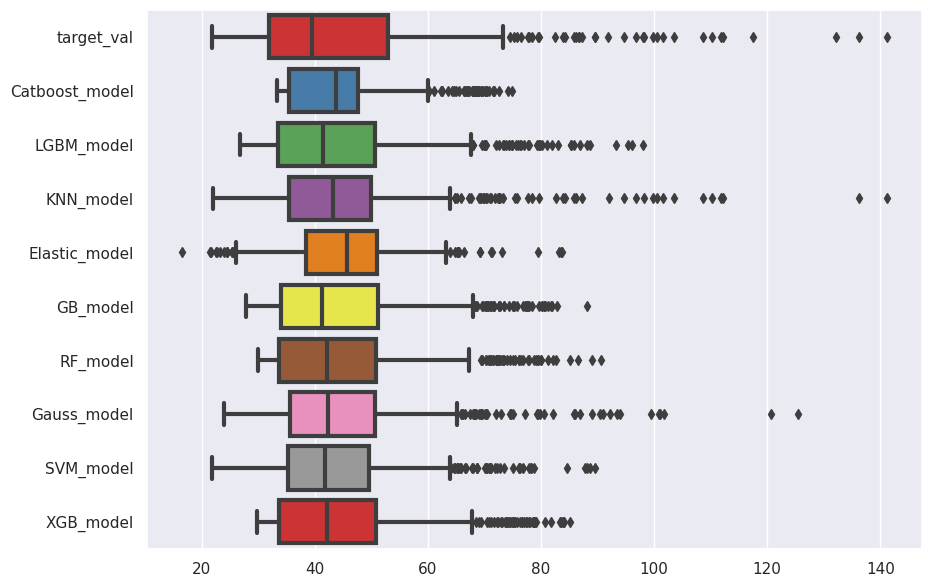

In [ ]:
sns.set(rc={"figure.figsize":(10, 7)})
sns.boxplot(data=df_val,whis=1,linewidth=3,orient="h",palette="Set1")

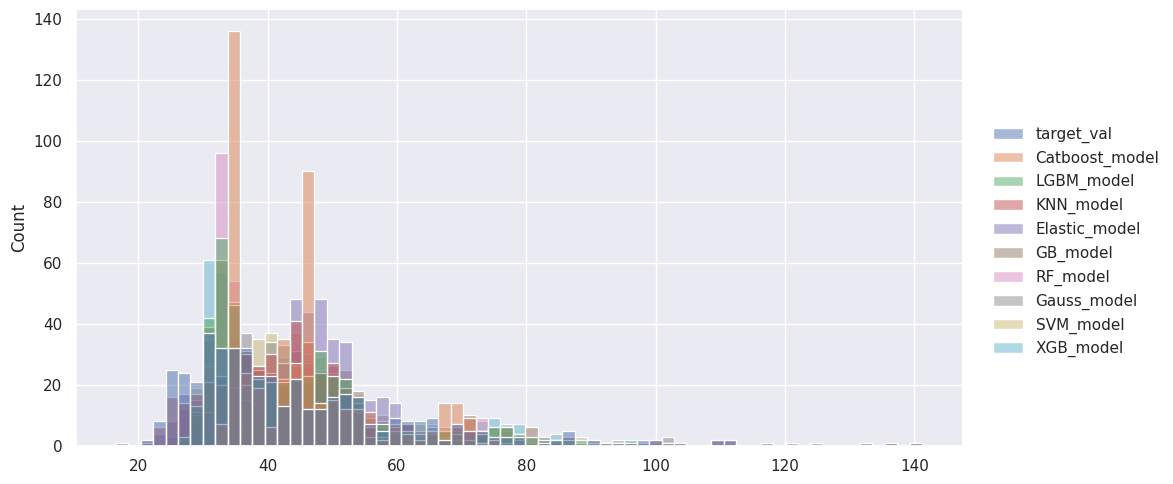

In [ ]:
sns.displot(df_val, kind="hist", aspect=2)

По распределению можно предположить, что простые модели, например, KNN и Gauss очень хорошо предсказывают валидационную выборку. Но они у меня просто переобучались при подборе параметров на optuna, поэтому будем ориентироваться на показатели RMSE по кросс-валидации.

Но видно, что модели Catboost и LGBM достаточно плохо предсказывают экстремальные значения таргета. Вероятно этих значений не так много и модели не очень хорошо на них обучаются. Попытаемся скомпенсировать это добавив к нашим бустингам линейную модель. Для блендинга нам требуется взять 2 бустинга и одну модель не бустинг. Возьмём в наш набор для блендинга Catboost, LGBM и KNN.

In [ ]:
df_sub_blending = df_sub[['car_id',
                          'Catboost_target',
                          'LGBM_target',
                          'KNN_target',]]
df_sub_blending.head()

,car_id,Catboost_target,LGBM_target,KNN_target
0,P17494612l,46.734139,51.624701,42.158554
1,N-1530212S,35.766222,34.382361,43.264945
2,B-1154399t,34.374031,30.583014,37.782325
3,F12725233R,35.012493,36.510600,43.918047
4,l-1139189J,35.915789,29.455351,47.391793


In [ ]:
scores_mdls_chosen = {}
for i in range(len(df_sub_blending.columns)):
    _ = re.sub(r'_target', '_score', df_sub_blending.columns[i])
    if _ in mean_scores:
        scores_mdls_chosen.update({_: mean_scores[_]})

scores_mdls_chosen

{'Catboost_score': 12.209002234450312,
 'LGBM_score': 12.097570837410302,
 'KNN_score': 15.139561066717908}

Можем высчитаем коэффициенты для блендинга автоматически, пропрорционально усреднённым метрикам. Но мне это давало результат хуже, чем выставление вручную. Поэтому оставил выставление вручную.

In [ ]:
# высчитаем веса для результатов модели пропорционально метрике RMSE
# scores = 1 / np.array(list(scores_mdls_chosen.values()))
# all_sum = np.sum(scores)
# weights_ = scores / all_sum
# # weights_

# weights = {}
# for f, b in zip(scores_mdls_chosen, weights_):
#     weights.update({f: b})
# print(weights)

# # домножим наши веса на колонки и сложим значения
# def forward(row):
#     average = 0
#     for el in scores_mdls_chosen:
#        _ = re.sub(r'_score', '_target', el)
#        average += row[_] * weights[el]

#     return average

# df_sub_blending['target_reg'] = df_sub.apply(forward, axis=1)

# код для ручного выставления весов
weights = [.45, .35, .2]
def forward(row):
    average = 0
    for i, el in enumerate(scores_mdls_chosen):
        _ = re.sub(r'_score', '_target', el)
        average += row[_] * weights[i]

    return average

df_sub_blending['target_reg'] = df_sub_blending.apply(forward, axis=1)
df_sub_blending.head()

,car_id,Catboost_target,LGBM_target,KNN_target,target_reg
0,P17494612l,46.734139,51.624701,42.158554,47.530719
1,N-1530212S,35.766222,34.382361,43.264945,36.781615
2,B-1154399t,34.374031,30.583014,37.782325,33.728834
3,F12725233R,35.012493,36.510600,43.918047,37.317942
4,l-1139189J,35.915789,29.455351,47.391793,35.949836


In [ ]:
# получаем предсказания от блендинга
df_sub_blending = df_sub_blending[['car_id', 'target_reg']]
df_sub_blending.to_csv('result_1.csv', index=False)

# Стекинг

Будем использовать стандартный sklearn стекинг.

In [ ]:
# список базовых моделей
estimators = [
    ("SVM", bst_mdls['SVM_model']),
    ("LightGBM", bst_mdls['GB_model']),
    ("CatBoost", bst_mdls['XGB_model']),
]

# в качестве мета-модели будем использовать linearRegression
meta_model = StackingRegressor(
    estimators=estimators,
    # final_estimator=NuSVR(verbose=False),
    final_estimator=RandomForestRegressor(n_estimators = 10_000,
                                           max_depth = 5,
                                           verbose=False),
    n_jobs=-1,
    verbose=False,
)

stacking_regressor = meta_model
stacking_regressor.fit(X, y)

StackingRegressor(estimators=[('SVMoost',
                               TransformedTargetRegressor(regressor=Pipeline(steps=[('feature_preprocessor',
                                                                                     ColumnTransformer(transformers=[('num',
                                                                                                                      Pipeline(steps=[('imputer',
                                                                                                                                       SimpleImputer(strategy='median')),
                                                                                                                                      ('scaler',
                                                                                                                                       StandardScaler())]),
                                                                                                                      ['car_rating',
                                                                                                                       'year_to_start',
                                                                                                                       'riders',
                                                                                                                       'year_to_work',
                                                                                                                       'mean_rating',
                                                                                                                       'distance_sum',
                                                                                                                       'rating_min',
                                                                                                                       'speed...
                                                                                                  max_bin=213,
                                                                                                  max_cat_threshold=None,
                                                                                                  max_cat_to_onehot=None,
                                                                                                  max_delta_step=None,
                                                                                                  max_depth=4,
                                                                                                  max_leaves=7,
                                                                                                  min_child_weight=5.106693512560915,
                                                                                                  missing=nan,
                                                                                                  monotone_constraints=None,
                                                                                                  n_estimators=268,
                                                                                                  n_jobs=-1, ...))]),
                                                          transformer=StandardScaler()))],
                  final_estimator=RandomForestRegressor(max_depth=5,
                                                        n_estimators=10000,
                                                        verbose=False),
                  n_jobs=-1, verbose=False)

In [ ]:
preds = stacking_regressor.predict(X_sub)
df_sub_stacking = df_sub[['car_id',]]
df_sub_stacking['target_reg'] = preds
df_sub_stacking.to_csv('result_2.csv', index=False)

In [ ]:
end = time.time()
all_time = (end - start) / 60
all_time

17.07263048092524

## pystack

In [ ]:
X_train = pd.get_dummies(X_train, columns=['model'], drop_first=True)
X_train

,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,mean_rating,distance_sum,rating_min,speed_max,...,model_Renault Sandero,model_Skoda Rapid,model_Smart Coupe,model_Smart ForFour,model_Smart ForTwo,model_Tesla Model 3,model_VW Polo,model_VW Polo VI,model_VW Tiguan,model_Volkswagen ID.4
1751,standart,petrol,5.039062,2012,19858,2016,4.226562,15794661.0,0.099976,109.000,...,0,0,0,0,0,0,0,0,0,0
80,economy,petrol,5.160156,2013,38432,2015,4.761719,9534394.0,0.649902,173.000,...,0,0,0,0,0,0,0,0,0,0
1227,economy,petrol,4.679688,2013,46865,2014,3.867188,10123541.0,0.099976,165.000,...,0,0,0,0,0,0,1,0,0,0
1736,business,petrol,5.441406,2014,60625,2017,4.269531,11333849.0,0.000000,184.625,...,0,0,0,0,0,0,0,0,0,0
1864,economy,petrol,3.240234,2016,104373,2020,4.796875,9889240.0,0.099976,181.625,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,economy,petrol,4.921875,2013,45440,2014,4.531250,9609943.0,0.099976,132.875,...,0,0,0,0,0,0,0,0,0,0
1731,economy,petrol,4.839844,2015,79545,2019,4.574219,10469001.0,0.099976,161.625,...,0,0,0,0,0,0,1,0,0,0
763,economy,petrol,5.000000,2015,78693,2021,4.355469,19217418.0,0.000000,182.375,...,0,0,0,0,0,0,0,0,0,0
835,economy,petrol,5.320312,2013,37237,2020,5.000000,13317720.0,0.099976,188.875,...,0,0,0,0,0,0,0,0,0,0


# Ансамбль

In [ ]:
!git clone https://github.com/MLWave/Kaggle-Ensemble-Guide

Cloning into 'Kaggle-Ensemble-Guide'...
remote: Enumerating objects: 116, done.
remote: Total 116 (delta 0), reused 0 (delta 0), pack-reused 116
Receiving objects: 100% (116/116), 23.29 KiB | 3.33 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [ ]:
!python /content/Kaggle-Ensemble-Guide/src/kaggle_vote.py '/content/result_*.csv'  '/content/all.csv'

parsing: /content/result_1.csv
parsing: /content/result_2.csv
wrote to /content/all.csv


In [ ]:
#res_2 RMSE вашего решения 12.1. Нужно не более 11.85
# res_1 RMSE вашего решения 12.3. Нужно не более 11.85
# all RMSE вашего решения 12.3. Нужно не более 11.85

In [ ]:
!python /content/Kaggle-Ensemble-Guide/src/kaggle_geomean.py "/content/result_*.csv" "/content/all_mean.csv" # "weighted"

parsing: /content/result_1.csv
parsing: /content/result_2.csv
wrote to /content/all_geomean1.csv


# Результаты и выводы.

* Обучили несколько моделей. Многие модели не попали в окончательное решение. (MLPregressor, самописный MLPRegressor, )